In [1]:
import mne
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.signal import butter, filtfilt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from adan_pytorch import Adan

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from IPython.display import clear_output

In [2]:
PATH = "/home/gromov_n/MASS/ss2/"

### Loading and preprocess data

In [3]:
def ReadSignals():
    all_data = {}
    for file in tqdm(os.listdir(PATH)):
        if "PSG" in file:
            data = mne.io.read_raw_edf(PATH + file, verbose=False)
            raw_data = data.get_data()

            labels = np.load("../data/" + file + "labels.npy")
            assert len(labels) == len(raw_data[0])
            number = int(file[8:10])
            all_data[number] = [raw_data, labels]
           
            data.close()
    return all_data

In [4]:
all_data = ReadSignals()
assert len(all_data) == 19

100%|██████████████████████████████████████████████████████████████████| 97/97 [02:24<00:00,  1.49s/it]


Тест и невалидные данные (из статьи)

In [5]:
IDS_INVALID = [4, 8, 15, 16]  # Only 1 expert 
IDS_TEST = [13, 12, 2, 6]

In [3]:
def broad_filter(signal, fs, lowcut=0.1, highcut=35):
    """Returns filtered signal sampled at fs Hz, with a [lowcut, highcut] Hz
    bandpass."""
    # Generate butter bandpass of order 3.
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, (low, high), btype='band')
    # Apply filter to the signal with zero-phase.
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [7]:
for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        print(key)

100%|███████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 87766.27it/s]

12
6
2
13


In [8]:
train_data = []
train_labels = []

test_data = []
test_labels = []

for key, values in tqdm(all_data.items()):
    if key in IDS_TEST:
        test_data.append(broad_filter(values[0], 256))
        test_labels.append(values[1])
    elif key not in IDS_INVALID:
        train_data.append(broad_filter(values[0], 256))
        train_labels.append(values[1])
assert len(train_data) == 11
assert len(test_data) == 4     

100%|██████████████████████████████████████████████████████████████████| 19/19 [06:30<00:00, 20.55s/it]


In [9]:
for i in range(len(train_data)):
    train_data[i] = torch.FloatTensor(train_data[i].copy())#.to("cuda")
    new_trainl = torch.zeros(2, len(train_labels[i]))
    new_trainl = (torch.arange(2) == torch.LongTensor(train_labels[i])[:,None]).T
    new_trainl = new_trainl.float()
    train_labels[i] = new_trainl#.to("cuda")

for i in range(len(test_data)):
    test_data[i] = torch.FloatTensor(test_data[i].copy())#.to("cuda")
    new_testl = torch.zeros(2, len(test_labels[i]))
    new_testl = (torch.arange(2) == torch.LongTensor(test_labels[i])[:,None]).T
    new_testl = new_testl.float()
    test_labels[i] = new_testl#.to("cuda")

### Collecting predicts

In [4]:
def MergeClose(predictions, threshold):
    i = 0
    in_event = False
    while i < len(predictions):
        while i < len(predictions) and predictions[i] == 1:
            in_event = True
            i += 1
        if  i < len(predictions) and in_event:
            if np.any(predictions[i:i+threshold]):
                while  i < len(predictions) and predictions[i] == 0:
                    predictions[i] = 1
                    i += 1
            else:
                in_event = False
        i += 1

def DeleteShortEvents(predictions, threshold):
    i = 0
    while i < len(predictions):
        event_len = 0
        event_idx_start = i
        while i < len(predictions) and predictions[i] == 1:
            i += 1
            event_len += 1
        if event_len < threshold:
            predictions[event_idx_start:i] = 0
        i += 1
def PostProcessing(predictions, threshold):
    MergeClose(predictions, threshold)
    DeleteShortEvents(predictions, threshold)

In [5]:
threshold = 30

### Results

In [13]:
all_preds_seed_segm = []

for i in range(len(test_labels)):
    all_preds_seed_segm.append(np.load("../predicts/SEED/predsSEED4000_520Overlap" + str(i) + ".npy"))
    
    

In [14]:
all_preds_seed_test_right_order = []
for val in [1, 3, 2, 0]:
    PostProcessing(all_preds_seed_segm[val], threshold)
    all_preds_seed_test_right_order.append(all_preds_seed_segm[val])

#### Raw labels

In [16]:
def GetRawMetricsAndCM(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])
        lens.append(pred_len)
        sums.append((predictions[i] == test_labels[i][1, :pred_len].numpy()).sum())      

        acc.append(sums[i] / lens[i])
        precision.append(precision_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        recall.append(recall_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        f1.append(f1_score(test_labels[i][1, :pred_len].numpy(), predictions[i]))
        

        cm = confusion_matrix(test_labels[i][1, :pred_len].numpy(), predictions[i])
        all_cm += cm
        print("=============Record " + str(i) + "================")
        print("accuracy", acc[i])
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    print("Full accuracy", np.sum(sums)/np.sum(lens))
    print("Mean accuracy", np.mean(acc))
    print("Mean precision", np.mean(precision))
    print("Mean recall", np.mean(recall))
    print("Mean f1", np.mean(f1))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()
    

#### EpiSpike

In [17]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    while i < len(pred_labels):
        while true_labels[i] == 1:
            is_true_flag = 1
            if pred_labels[i] == 1:
                is_pred_flag = 1
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN              

In [18]:
def GetRawMetricsAndCMEPI(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            

        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        print("=============Record " + str(i) + "================")
    
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    
    
    print("Full precision", TP_sum / (TP_sum + FP_sum))
    print("Full recall", TP_sum / (TP_sum + FN_sum))
    print("Full f1", 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()

##### Postprocessed

In [6]:
OVERLAP = 520
test_labels_overlap = [labels[:, OVERLAP:] for labels in test_labels]

NameError: name 'test_labels' is not defined

=============Record 0================
precision 0.8486281929990539
recall 0.7199036918138042
f1 score 0.7789839339991316
=============Record 1================
precision 0.9066666666666666
recall 0.4817001180637544
f1 score 0.6291441788743254
=============Record 2================
precision 0.954639175257732
recall 0.8327338129496403
f1 score 0.8895292987512008
=============Record 3================
precision 0.8131067961165048
recall 0.9146757679180887
f1 score 0.8609058785737231
===========ALL RECORDS SCORE==================
Full precision 0.8826300294406281
Full recall 0.7777585610515393
Full f1 0.8268824124298979
Full Confusion Matrix


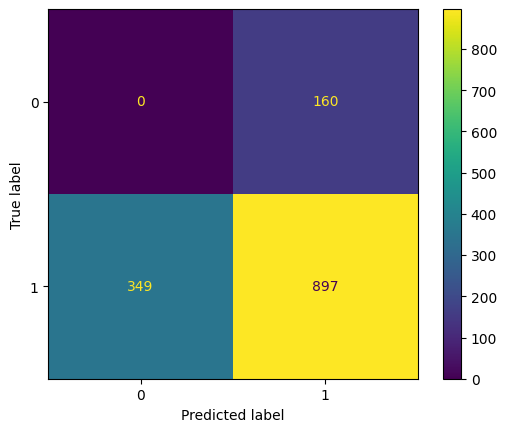

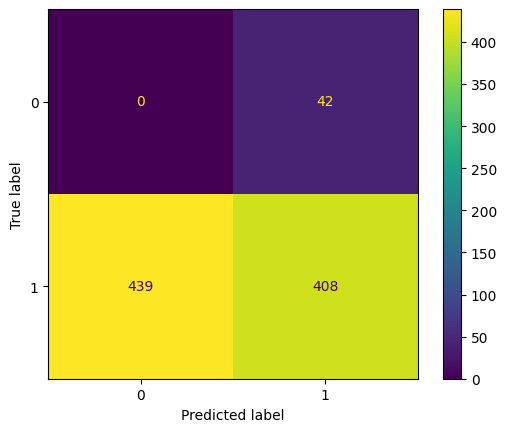

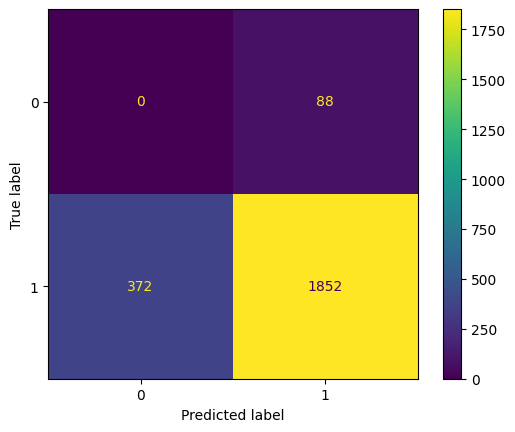

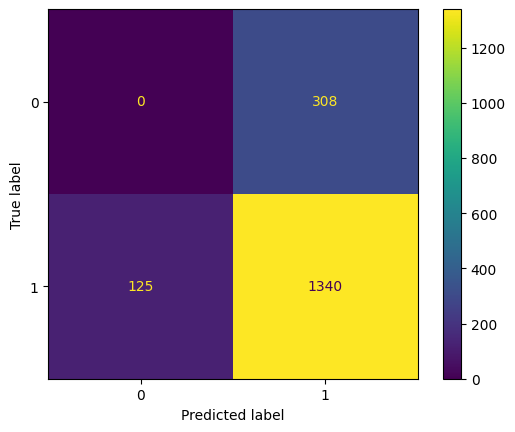

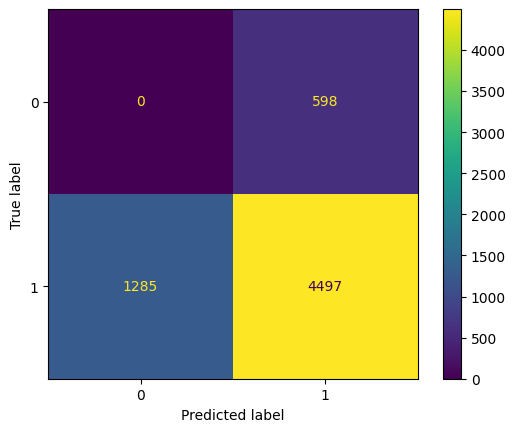

In [19]:
GetRawMetricsAndCMEPI(all_preds_seed_test_right_order, test_labels_overlap)

#### Characteristics

In [7]:
def CollectAmplitude(x):
    amplitudes = np.max(x[:19], axis=1)
    return amplitudes.mean()

In [8]:
def CollectFreq(x):
    centered_x = x[:19] - np.mean(x[:19], axis=1)[..., None]
    zero_cross_num = ((centered_x[:, :-1] * centered_x[:, 1:]) < 0).sum(axis=1)
    return zero_cross_num.mean() / x.shape[1]

In [9]:
def CollectCharacteristics(x, labels):  
    lens = []
    ampls = []
    freqs = []
    
    c = 0
    in_event = False
    for i in range(len(labels)):
        if labels[i] == 1:
            if not in_event:
                idx_start = i
            in_event = True
            c += 1
        elif in_event:
            ampls.append(CollectAmplitude(x[:, idx_start:i]))
            freqs.append(CollectFreq(x[:, idx_start:i]))
            lens.append(c)
            c = 0
            in_event = False
                
    return np.mean(lens), np.mean(ampls), np.mean(freqs), len(lens)   

In [10]:
def CreateSamplesCharacteristics(x, true_labels, pred_labels, window=10, sr=256): #window in minutes
    sample_window = window * 60 * sr
    inout_seq_labels = []
    inout_seq_characteristics_true = []
    inout_seq_characteristics_pred = []
    for i in range(0, x.shape[1] - sample_window, sample_window):
        if (true_labels[i:i + sample_window]).max() == 1:
            train_seq = x[:, i:i+sample_window].numpy()
            true_label = true_labels[i:i+sample_window].numpy()
            pred_label = pred_labels[i:i+sample_window]
            duration_true, amplitude_true, freq_true, ss_number_true = CollectCharacteristics(train_seq, true_label)
            duration_pred, amplitude_pred, freq_pred, ss_number_pred = CollectCharacteristics(train_seq, pred_label)
            
            inout_seq_characteristics_true.append(np.array([duration_true, amplitude_true, freq_true, ss_number_true]))
            inout_seq_characteristics_pred.append(np.array([duration_pred, amplitude_pred, freq_pred, ss_number_pred]))
    return inout_seq_characteristics_true, inout_seq_characteristics_pred

##### SEED Chars


In [65]:
all_answers = np.load("../predicts/SEEDNetTrueAllEpochs.npy")
all_preds = np.load("../predicts/SEEDNetPredsAllEpochs.npy")

In [54]:
mean = 3.446767e-05
std = 9.272679e-06

all_preds[1] = all_preds[1] * std + mean
all_preds[1] = (all_preds[1] - all_preds[1].mean()) / all_preds[1].std()

In [66]:
abs_difs = []
for i in range(4):
    abs_difs.append(np.abs(all_answers[i] - all_preds[i]))

Text(0.5, 1.0, 'Number hist')

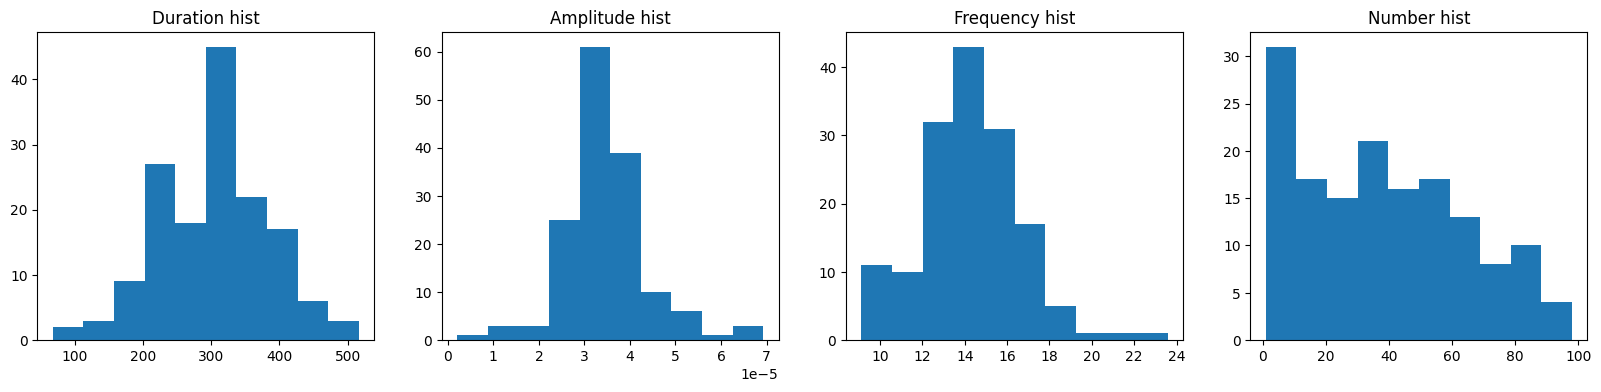

In [59]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(all_answers[0])
axes[0].set_title("Duration hist")

axes[1].hist(all_answers[1] * std + mean)
axes[1].set_title("Amplitude hist")

axes[2].hist(all_answers[2] * 256)
axes[2].set_title("Frequency hist")

axes[3].hist(all_answers[3])
axes[3].set_title("Number hist")

Text(0.5, 1.0, 'Number hist')

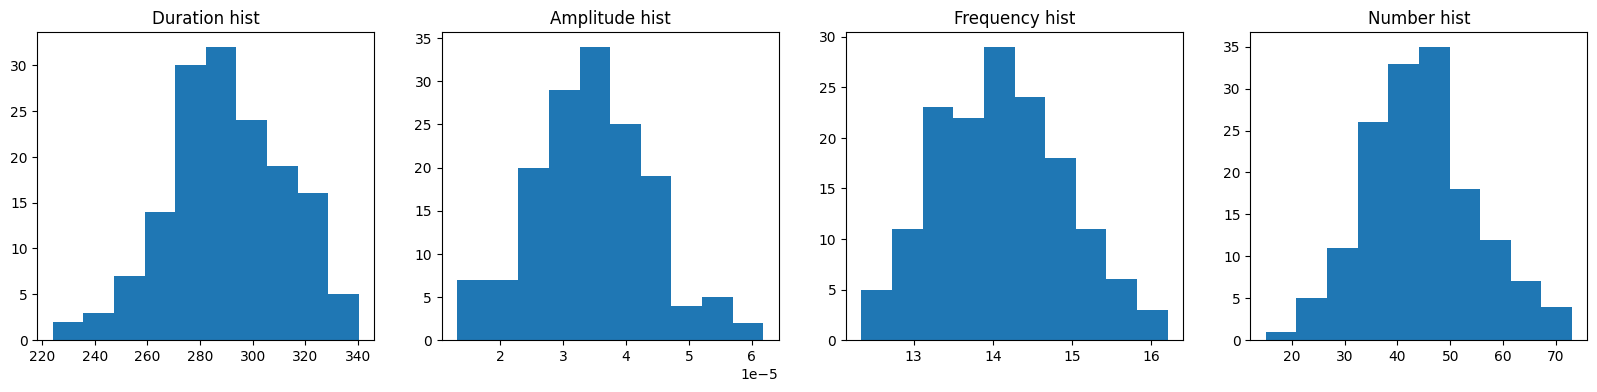

In [47]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(all_preds[0])
axes[0].set_title("Duration hist")

axes[1].hist(all_preds[1])
axes[1].set_title("Amplitude hist")

axes[2].hist(all_preds[2] * 256)
axes[2].set_title("Frequency hist")

axes[3].hist(all_preds[3])
axes[3].set_title("Number hist")

Text(0.5, 1.0, 'Number')

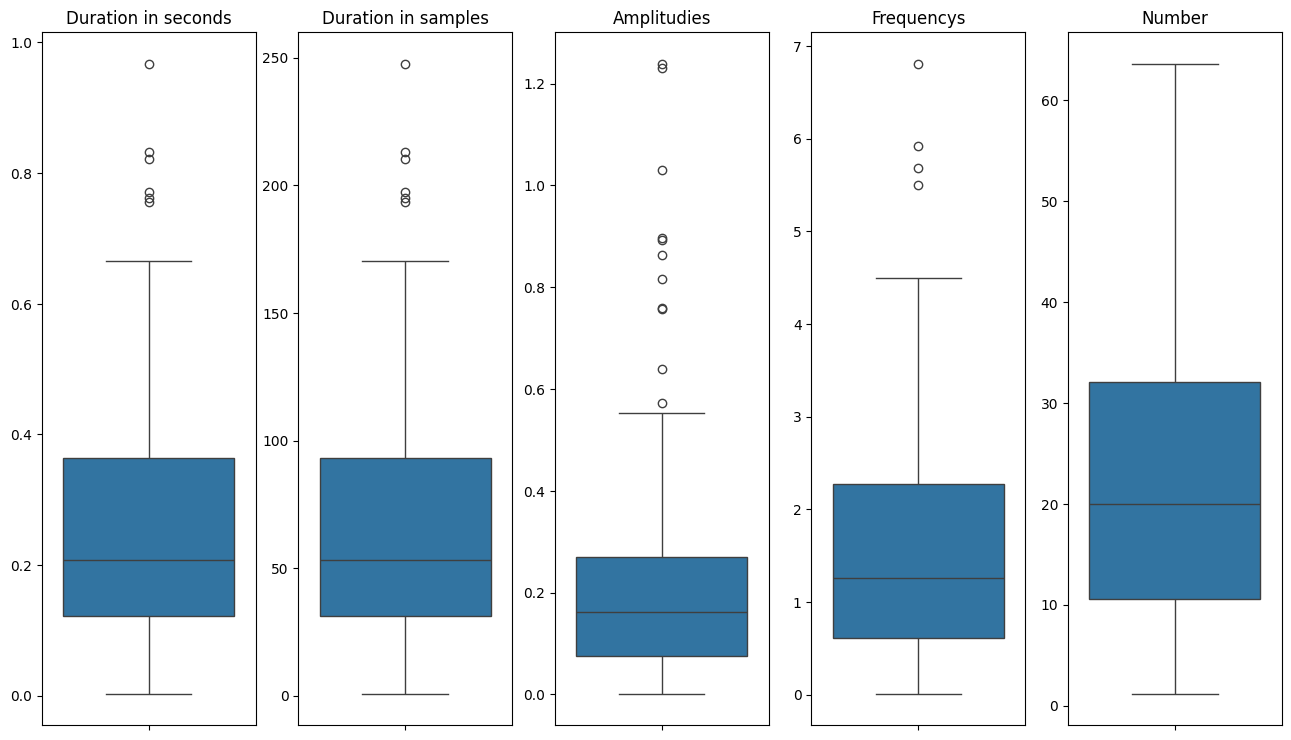

In [65]:
f, axes = plt.subplots(1, 5, figsize=(16, 9))
sns.boxplot(abs_difs[0] / 256, ax=axes[0])
axes[0].set_title("Duration in seconds")
sns.boxplot(abs_difs[0], ax=axes[1])
axes[1].set_title("Duration in samples")

sns.boxplot(abs_difs[1], ax=axes[2])
axes[2].set_title("Amplitudies")
sns.boxplot(abs_difs[2] * 256, ax=axes[3])
axes[3].set_title("Frequencys")

sns.boxplot(abs_difs[3], ax=axes[4])
axes[4].set_title("Number")


##### SEED

In [34]:
test_samples_char_true = []
test_samples_char_pred = []

for i in range(len(test_data)):
    inout_seq_char_true, inout_seq_char_pred = CreateSamplesCharacteristics(test_data[i][:, OVERLAP:], test_labels_overlap[i][1],
                                                                            all_preds_seed_test_right_order[i])
    test_samples_char_true += inout_seq_char_true
    test_samples_char_pred += inout_seq_char_pred    

/home/gromov_n/nikolay/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gromov_n/nikolay/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [48]:
test_samples_char_pred_post_proc = [test_samples_char_pred[i] for i in range(len(test_samples_char_pred)) if not np.isnan(test_samples_char_pred[i]).any()]
test_samples_char_true_post_proc = [test_samples_char_true[i] for i in range(len(test_samples_char_pred)) if not np.isnan(test_samples_char_pred[i]).any()]

test_samples_char_pred_post_proc = np.array(test_samples_char_pred_post_proc)
test_samples_char_true_post_proc = np.array(test_samples_char_true_post_proc)

test_samples_char_pred_post_proc[:, 2] *= 256
test_samples_char_true_post_proc[:, 2] *= 256

In [49]:
abs_dif = np.abs(test_samples_char_pred_post_proc - test_samples_char_true_post_proc)
abs_dif = abs_dif.T

Text(0.5, 1.0, 'Number hist')

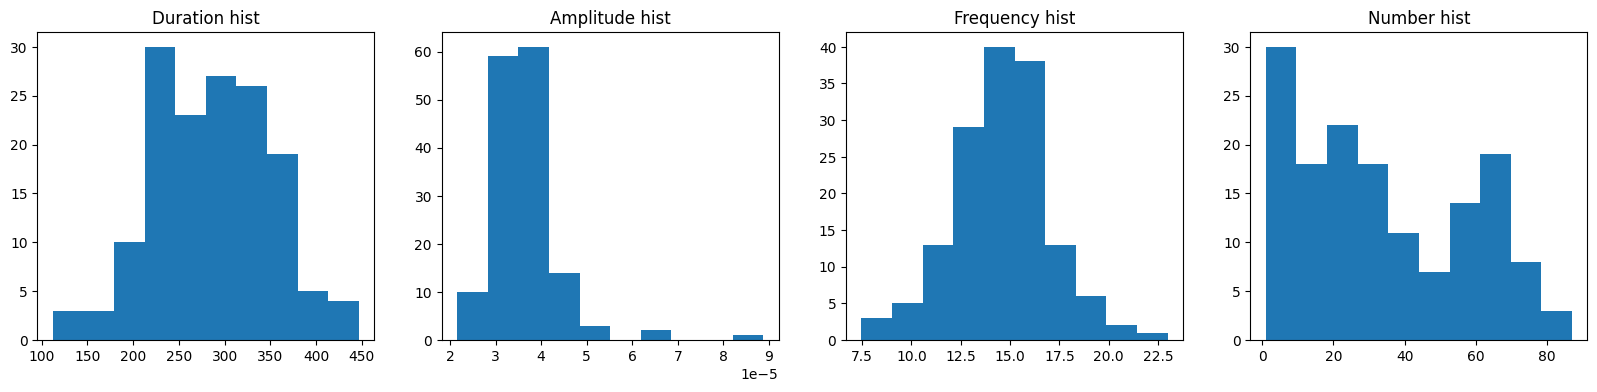

In [31]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(test_samples_char_pred_post_proc[:, 0])
axes[0].set_title("Duration hist")

axes[1].hist(test_samples_char_pred_post_proc[:, 1])
axes[1].set_title("Amplitude hist")

axes[2].hist(test_samples_char_pred_post_proc[:, 2])
axes[2].set_title("Frequency hist")

axes[3].hist(test_samples_char_pred_post_proc[:, 3])
axes[3].set_title("Number hist")

 ### amplitude is in Volts

Text(0.5, 1.0, 'Number hist')

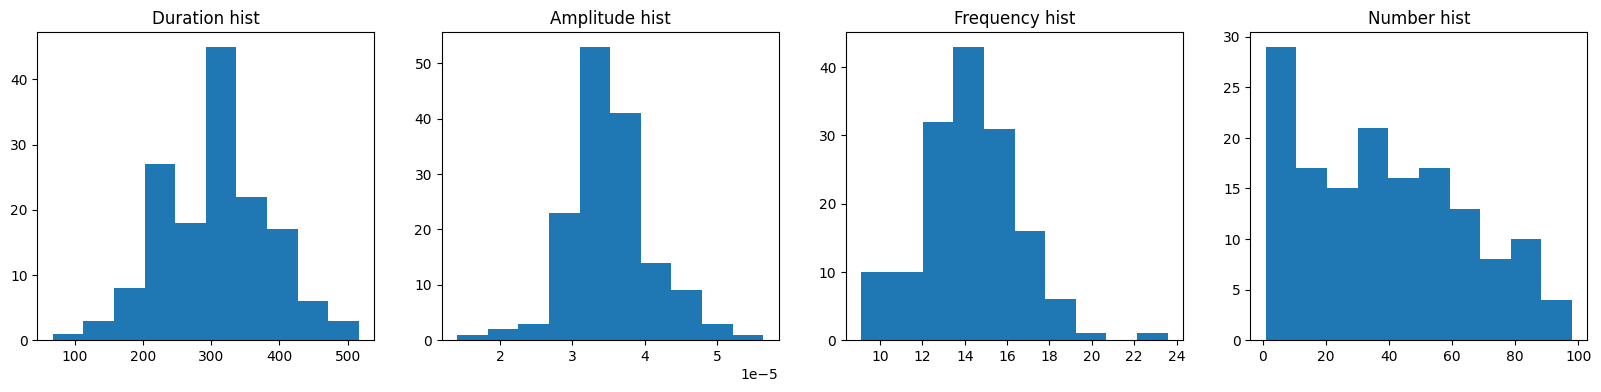

In [25]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(test_samples_char_true_post_proc[:, 0])
axes[0].set_title("Duration hist")

axes[1].hist(test_samples_char_true_post_proc[:, 1])
axes[1].set_title("Amplitude hist")

axes[2].hist(test_samples_char_true_post_proc[:, 2])
axes[2].set_title("Frequency hist")

axes[3].hist(test_samples_char_true_post_proc[:, 3])
axes[3].set_title("Number hist")

Text(0.5, 1.0, 'Number hist')

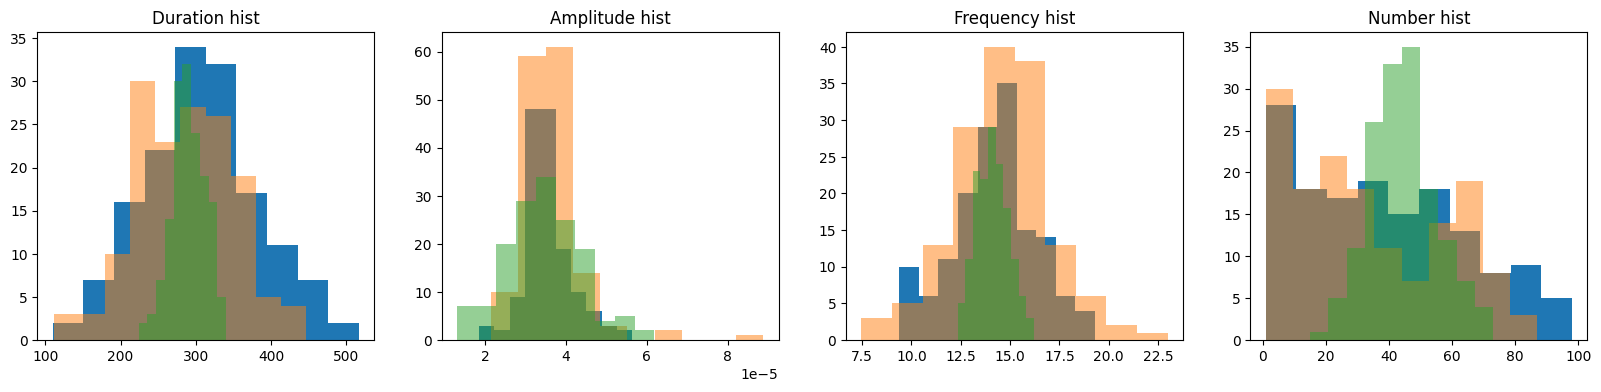

In [50]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(test_samples_char_true_post_proc[:, 0])
axes[0].hist(test_samples_char_pred_post_proc[:, 0], alpha=0.5)
axes[0].hist(all_preds[0], alpha=0.5)


axes[0].set_title("Duration hist")

axes[1].hist(test_samples_char_true_post_proc[:, 1])
axes[1].hist(test_samples_char_pred_post_proc[:, 1], alpha=0.5)
axes[1].hist(all_preds[1], alpha=0.5)


axes[1].set_title("Amplitude hist")

axes[2].hist(test_samples_char_true_post_proc[:, 2])
axes[2].hist(test_samples_char_pred_post_proc[:, 2], alpha=0.5)
axes[2].hist(all_preds[2] * 256, alpha=0.5)


axes[2].set_title("Frequency hist")

axes[3].hist(test_samples_char_true_post_proc[:, 3])
axes[3].hist(test_samples_char_pred_post_proc[:, 3], alpha=0.5)
axes[3].hist(all_preds[3], alpha=0.5)


axes[3].set_title("Number hist")

Text(0.5, 1.0, 'Number')

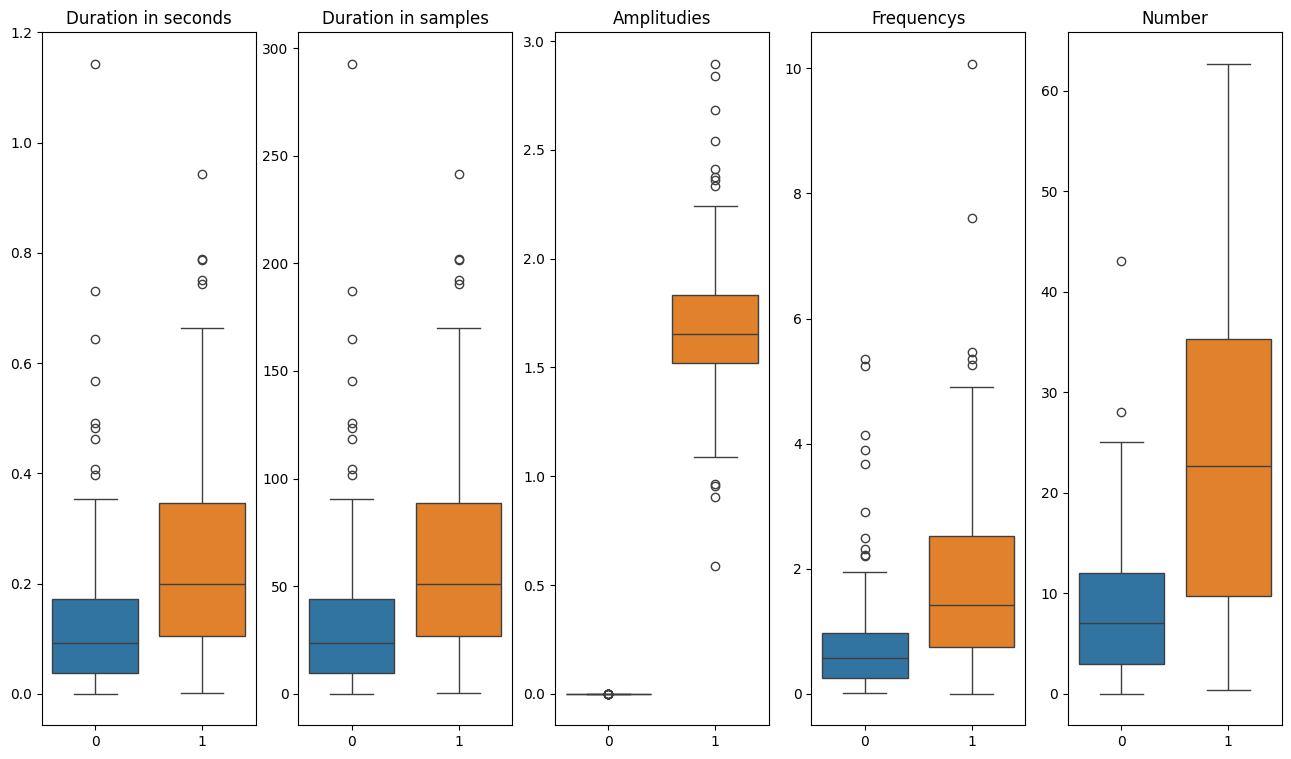

In [51]:
f, axes = plt.subplots(1, 5, figsize=(16, 9))
sns.boxplot([abs_dif[0] / 256, abs_difs[0] / 256], ax=axes[0])
axes[0].set_title("Duration in seconds")
sns.boxplot([abs_dif[0], abs_difs[0]], ax=axes[1])
axes[1].set_title("Duration in samples")

sns.boxplot([abs_dif[1], abs_difs[1]], ax=axes[2])
axes[2].set_title("Amplitudies")
sns.boxplot([abs_dif[2], abs_difs[2] * 256], ax=axes[3])

axes[3].set_title("Frequencys")

sns.boxplot([abs_dif[3], abs_difs[3]], ax=axes[4])
axes[4].set_title("Number")

(0.0, 200.0)

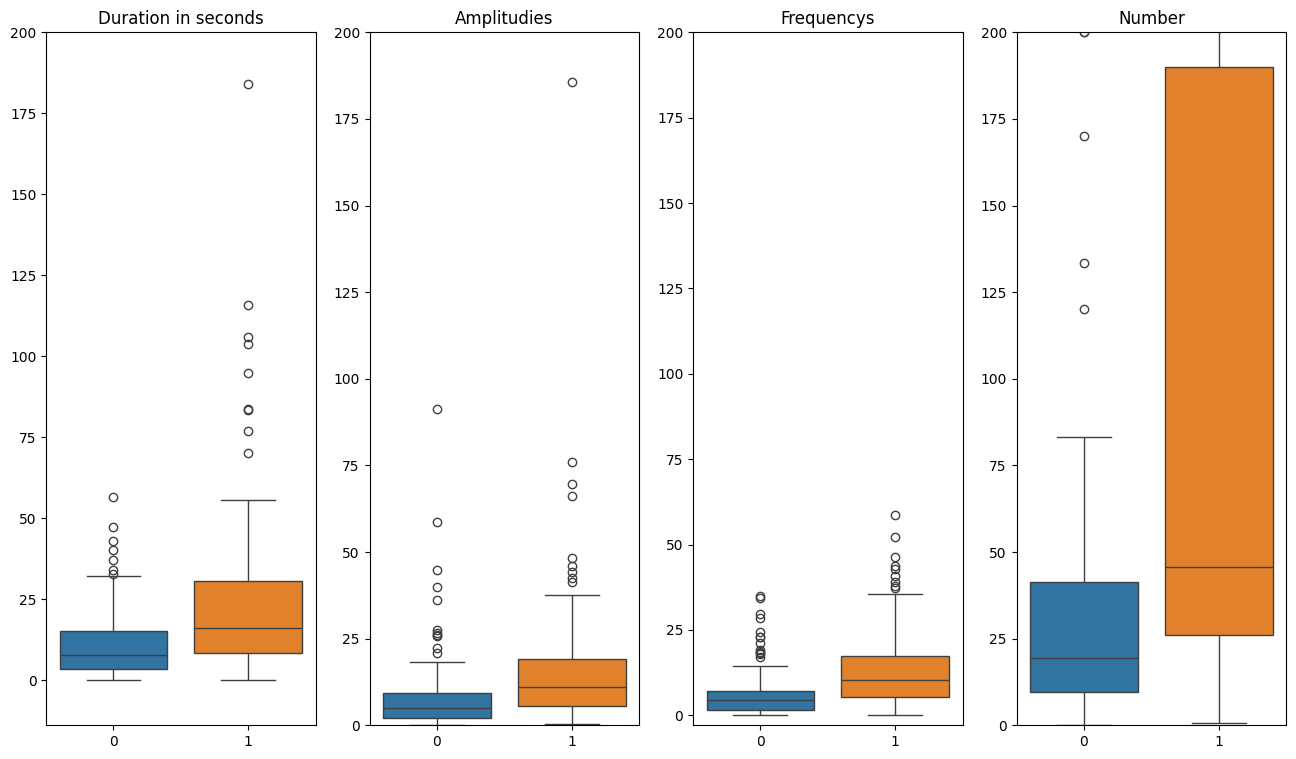

In [67]:
f, axes = plt.subplots(1, 4, figsize=(16, 9))
sns.boxplot([abs_dif[0] / test_samples_char_true_post_proc.T[0] * 100, abs_difs[0] / all_answers[0] * 100], ax=axes[0])
axes[0].set_title("Duration in seconds")
# sns.boxplot([abs_dif[0], abs_difs[0]], ax=axes[1])
# axes[1].set_title("Duration in samples")
axes[0].set_ylim(top=200)

sns.boxplot([abs_dif[1] / test_samples_char_true_post_proc.T[1] * 100, abs_difs[1] / all_answers[1] * 100], ax=axes[1])
axes[1].set_title("Amplitudies")
axes[1].set_ylim(bottom=0, top=200)

sns.boxplot([abs_dif[2] / test_samples_char_true_post_proc.T[2] * 100, abs_difs[2] / all_answers[2] * 100], ax=axes[2])

axes[2].set_title("Frequencys")
axes[2].set_ylim(top=200)


sns.boxplot([abs_dif[3] / test_samples_char_true_post_proc.T[3] * 100, abs_difs[3] / all_answers[3]* 100], ax=axes[3])
axes[3].set_title("Number")
axes[3].set_ylim(bottom=0, top=200)


# Epi

In [11]:
def ReadSignal(file_name): 

    f = pyedflib.EdfReader(file_name)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((20, f.getNSamples()[0])) #or n
    
    if n == 22:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(21)
    elif n == 23:
        for i in np.arange(19):
            sigbufs[i, :] = f.readSignal(i)
        sigbufs[19, :] = f.readSignal(20)
    else:
        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)

    time = [1/f.samplefrequency(0) * i for i in range(len(sigbufs[0]))]

    annotations = f.readAnnotations()  


    new_annot = [(annotations[0][i], annotations[1][i], annotations[2][i])  
                 for i in range(len(annotations[0])) 
                                if (annotations[1][i] > 0) and (annotations[2][i] in ['?', 'Ð²Ñ\x81', 'Ð²Ñ\x81?'])]
    f.close()
    return sigbufs, new_annot, time, f.samplefrequency(0)

In [12]:
path = "../"
record_names = ["MoscowSpecialistsData/P2.edf", 
                "MoscowSpecialistsData/P3.edf", 
                "MoscowSpecialistsData/P4.edf", 
                "MoscowSpecialistsData/P5.edf", 
                "MoscowSpecialistsData/P6.edf"] 
                #"MoscowSpecialistsData/P8.edf"]

records = []
annots = []
times = []
freqs = []
for file_name in record_names:

    sigbufs, new_annot, time, freq = ReadSignal(path + file_name)
    records.append(broad_filter(sigbufs, 199))

    annots.append(new_annot)
    times.append(time)
    freqs.append(freq)
    

In [13]:
def NormalizeAndClip(data):
    for i in tqdm(range(len(data))):
        signal = data[i]
        means = signal.mean(axis=1)[..., None]
        stds = signal.std(axis=1)[..., None]
        signal = np.clip((signal - means) / stds, a_min=-10, a_max=10)
        data[i] = signal

In [14]:
normalized_records = [records[i].copy() for i in range(len(records))]
NormalizeAndClip(normalized_records)    

100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]


In [16]:
epi_labels = []

for i in range(len(records)):
    if "Moscow" in record_names[i]:
        epi_labels.append(np.load(path + "MoscowSpecialistsData/Labels/" + 
                                  record_names[i][22:] + "freq" + str(freqs[i])[:3] + ".npy"))

In [17]:
means = []
stds = [] 
for i in range(len(records)):
    inout_seq_char_true, inout_seq_char_pred = CreateSamplesCharacteristics(torch.FloatTensor(records[i].copy()), 
                                                                            torch.LongTensor(epi_labels[i].copy()),
                                                                            torch.LongTensor(epi_labels[i].copy()), 
                                                                            window=2, sr=199)
    means.append(np.mean(inout_seq_char_true, axis=0))
    stds.append(np.std(inout_seq_char_true, axis=0))

In [26]:
epi_data = []
epi_data_normalized = []
for i in range(len(records)):
    time_start = annots[i][0][0]
    time_end = annots[i][-1][0]
    idx_start = (np.array(times[i]) <= time_start).argmin()
    idx_fin = (np.array(times[i]) < time_end).argmin()        

    epi_data.append(torch.FloatTensor(records[i][:, idx_start:idx_fin].copy()))
    epi_data_normalized.append(torch.FloatTensor(normalized_records[i][:, idx_start:idx_fin].copy()))

    

    current_labels = epi_labels[i][idx_start:idx_fin]
    new_trainl = torch.zeros(2, len(current_labels))
    new_trainl = (torch.arange(2) == torch.LongTensor(current_labels)[:,None]).T
    new_trainl = new_trainl.float()
    epi_labels[i] = new_trainl

In [27]:
class MDB_block(nn.Module):
    def __init__(self, k, F):
        super(MDB_block, self).__init__()

        #print(F, k)
        self.conv11 = nn.Conv1d(F, F//2, kernel_size=k, dilation=1, padding=(k-1)//2) #p = d * (k-1) / 2
        self.bn11 = nn.BatchNorm1d(F//2)
        self.conv12 = nn.Conv1d(F, F//4, kernel_size=k, dilation=2, padding=k-1) 
        self.bn12 = nn.BatchNorm1d(F//4)
        self.conv13 = nn.Conv1d(F, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn13 = nn.BatchNorm1d(F//8)
        self.conv14 = nn.Conv1d(F, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn14 = nn.BatchNorm1d(F//8)

        self.conv21 = nn.Conv1d(F//2, F//2, kernel_size=k, dilation=1, padding=(k-1)//2)
        self.bn21 = nn.BatchNorm1d(F//2)
        self.conv22 = nn.Conv1d(F//4, F//4, kernel_size=k, dilation=2, padding=k-1)
        self.bn22 = nn.BatchNorm1d(F//4)
        self.conv23 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=4, padding=2*(k-1))
        self.bn23 = nn.BatchNorm1d(F//8)
        self.conv24 = nn.Conv1d(F//8, F//8, kernel_size=k, dilation=8, padding=4*(k-1))
        self.bn24 = nn.BatchNorm1d(F//8)

        self.relu = nn.ReLU()

        
    
    def forward(self,x):

        x1 = self.conv11(x)
        x1 = self.bn11(x1)
        x1 = self.relu(x1)
        x1 = self.conv21(x1)
        x1 = self.bn21(x1)
        x1 = self.relu(x1)
        
        x2 = self.conv12(x)
        x2 = self.bn12(x2)
        x2 = self.relu(x2)
        x2 = self.conv22(x2)
        x2 = self.bn22(x2)
        x2 = self.relu(x2)

        x3 = self.conv13(x)
        x3 = self.bn13(x3)
        x3 = self.relu(x3)
        x3 = self.conv23(x3)
        x3 = self.bn23(x3)
        x3 = self.relu(x3)

        x4 = self.conv14(x)
        x4 = self.bn14(x4)
        x4 = self.relu(x4)
        x4 = self.conv24(x4)
        x4 = self.bn24(x4)
        x4 = self.relu(x4)

        
        return torch.concatenate([x1, x2, x3, x4], axis=1)  

class SEED(nn.Module):
    def __init__(self, overlap=0, input_dim=27, F = 64, q1=0.2, q2=0.5, N1=256, N2=128):
        super(SEED, self).__init__()

        self.N1 = N1
        
        self.bn = nn.BatchNorm1d(input_dim)
        self.conv1 = nn.Conv1d(input_dim, F, kernel_size=3, padding = 520 - overlap)
        self.bn1 = nn.BatchNorm1d(F)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(F, 2*F, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2*F)

        self.AvgPool1D = nn.AvgPool1d(2)

        self.mdb1 = MDB_block(3, 2*F)

        self.conv3 = nn.Conv1d(2*F, 4*F, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(4*F)
        
        self.mdb2 = MDB_block(3, 4*F)

        self.dropout1 = nn.Dropout(q1)
        self.dropout2 = nn.Dropout(q2)

        
        self.lstm1 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm1 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn3 = nn.BatchNorm1d(N1)

        self.lstm2 = nn.LSTM(N1, N1, num_layers=1, batch_first=True, bidirectional=True)
        self.convlstm2 = nn.Conv1d(2*N1, N1, kernel_size=1) #256?
        self.bn4 = nn.BatchNorm1d(N1)

        self.classifier1 = nn.Conv1d(N1, N2, kernel_size=1) 
        self.bn5 = nn.BatchNorm1d(N2)
        self.classifier2 = nn.Conv1d(N2, 2, kernel_size=1) 

        self.upsample = nn.Upsample(scale_factor=8, mode='nearest')

    def forward(self,x):
        x = self.bn(x)
        x = self.conv1(x)
        
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        
        
        x = self.bn2(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        
        
        x = self.mdb1(x)
        

        x = self.conv3(x)
        
        
        x = self.bn3(x)
        x = self.relu(x)

        x = self.AvgPool1D(x)
        
        
        x = self.mdb2(x)
        
        

        x = self.AvgPool1D(x)
        

        x = x[:, :, 65:-64]
        

        x = self.dropout1(x)

        lstm_out, (h_n, c_n) = self.lstm1(x.transpose(2, 1))

        

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)

        

        lstm_out, (h_n, c_n) = self.lstm2(x)

        

        x = lstm_out[:, :, :self.N1] + lstm_out[:, :, self.N1:]
        x = self.dropout2(x)
        
        x = x.transpose(2, 1)
        x = self.dropout2(x)
        

        x = self.classifier1(x)
        
        
        x = self.bn5(x)
        x = self.relu(x)

        x = self.classifier2(x)    
        

        x =self.upsample(x)    
        
    
        return x
        
        
        

In [28]:
OVERLAP = 520

model = SEED(OVERLAP, input_dim=20)

In [21]:
RECEPTIVE_FIELD = 4000
def CollectingPreds(model, test_data):

    model.eval()
    model.cpu()
    all_preds = []
    for i in range(len(test_data)):
        record_preds = []
        for idx in tqdm(range(OVERLAP, test_data[i].size()[1]- RECEPTIVE_FIELD - OVERLAP, RECEPTIVE_FIELD)):

            train_seq = test_data[i][:, idx-OVERLAP:idx+RECEPTIVE_FIELD+OVERLAP][None, ...]
                  
            out = model(train_seq)
            m = nn.Softmax(dim=1)
            out = m(out)
            
            preds = np.argmax(out.detach().cpu().numpy(), axis=1)
            record_preds.append(preds)
        shapes = np.array(record_preds).shape
        record_preds = np.array(record_preds).reshape(shapes[0] * shapes[1] * shapes[2])
        all_preds.append(record_preds)
    return all_preds

In [24]:
path = "../CrossValidationResults/6RecordsMetricOptThs30SEEDFixedMetric"
model_name = "SEED"

In [29]:
segm_model_predictions = []
for i in range(len(records)):
    model.load_state_dict(torch.load(path + "/Split" + str(i) +"/" + model_name, map_location=torch.device('cpu')))  
    all_preds = CollectingPreds(model, [epi_data_normalized[i]])
    PostProcessing(all_preds[0], 30)
    segm_model_predictions += all_preds

100%|███████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 16.82it/s]


In [30]:
def CollectingTPFPFN(pred_labels, true_labels):
    i = 0
    TP = 0
    FP = 0
    FN = 0

    is_true_flag = 0
    is_pred_flag = 0
    while i < len(pred_labels):
        while i < len(pred_labels) and true_labels[i] == 1:
            is_true_flag = 1
            if pred_labels[i] == 1:
                is_pred_flag = 1
            i += 1
        if is_true_flag:
            if is_pred_flag:
                TP += 1
            else:
                FN += 1
        
        is_true_flag = 0
        is_pred_flag = 0   
        i += 1

    i = 0
    while i < len(pred_labels):
        while i < len(pred_labels) and pred_labels[i] == 1:
            is_pred_flag = 1
            if true_labels[i] == 1:
                is_true_flag = 1
            i += 1
        if is_pred_flag and not is_true_flag:
            FP += 1
        is_pred_flag = 0
        is_true_flag = 0
        i += 1

    return TP, FP, FN 

def GetRawMetricsAndCMEPI(predictions, test_labels):
    lens = []
    sums = []

    acc = []
    precision = []
    recall = []
    f1 = []

    TP_sum = 0
    FP_sum = 0
    FN_sum = 0
    
    all_cm = 0
    for i in range(len(test_labels)):
        pred_len = len(predictions[i])

        TP, FP, FN = CollectingTPFPFN(predictions[i], test_labels[i][1, :pred_len].numpy())

        TP_sum += TP
        FP_sum += FP
        FN_sum += FN
            

        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
        f1.append(2 * TP / (2 * TP + FP + FN))
        

        cm = np.array([[0, FP], [FN, TP]])
        all_cm += cm
        print("=============Record " + str(i) + "================")
    
        print("precision", precision[i])
        print("recall", recall[i])
        print("f1 score", f1[i])
        
        ConfusionMatrixDisplay(cm).plot()
    print("===========ALL RECORDS SCORE==================")
    
    
    print("Full precision", TP_sum / (TP_sum + FP_sum))
    print("Full recall", TP_sum / (TP_sum + FN_sum))
    print("Full f1", 2 * TP_sum / (2 * TP_sum + FP_sum + FN_sum))   
    

    print("Full Confusion Matrix")
    ConfusionMatrixDisplay(all_cm).plot()

In [54]:
test_samples_char_true = []
test_samples_char_pred = []

for i in range(len(epi_data)):
    inout_seq_char_true, inout_seq_char_pred = CreateSamplesCharacteristics(epi_data[i][:, OVERLAP:], epi_labels[i][1][OVERLAP:],
                                                                            segm_model_predictions[i], window=2, sr=199)
    test_samples_char_true += inout_seq_char_true
    test_samples_char_pred += inout_seq_char_pred    

In [55]:
test_samples_char_true = np.array(test_samples_char_true)
test_samples_char_pred = np.array(test_samples_char_pred)

test_samples_char_true[:, 2] *= 256
test_samples_char_pred[:, 2] *= 256

In [56]:
epi_dif = np.abs(test_samples_char_true - test_samples_char_pred)

Text(0.5, 1.0, 'Number hist')

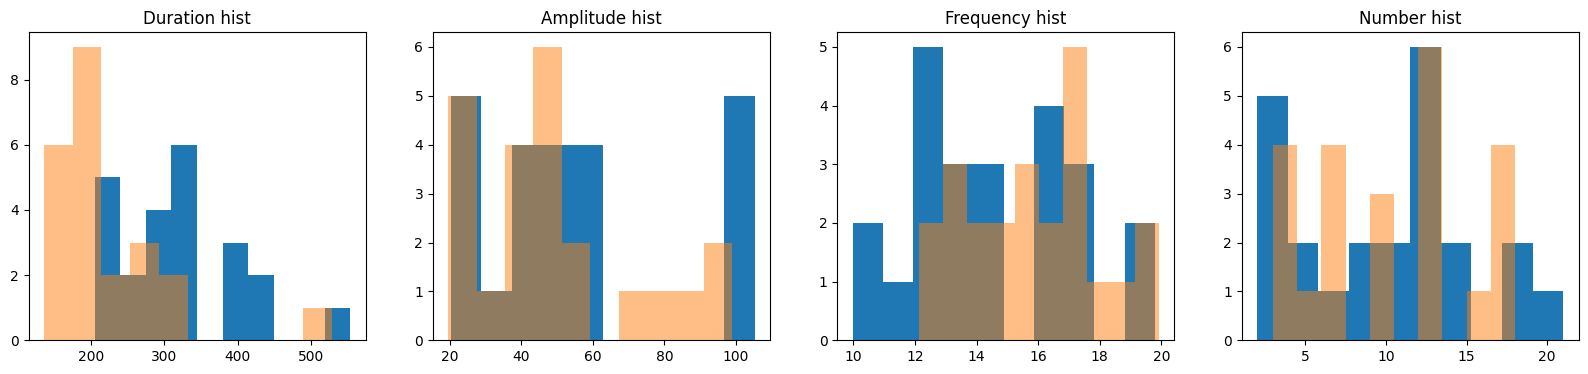

In [57]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(test_samples_char_true[:, 0])
axes[0].hist(test_samples_char_pred[:, 0], alpha=0.5)

axes[0].set_title("Duration hist")

axes[1].hist(test_samples_char_true[:, 1])
axes[1].hist(test_samples_char_pred[:, 1], alpha=0.5)

axes[1].set_title("Amplitude hist")

axes[2].hist(test_samples_char_true[:, 2])
axes[2].hist(test_samples_char_pred[:, 2], alpha=0.5)

axes[2].set_title("Frequency hist")

axes[3].hist(test_samples_char_true[:, 3])
axes[3].hist(test_samples_char_pred[:, 3], alpha=0.5)

axes[3].set_title("Number hist")

# Epi SlumberNet

In [39]:
train_records_mean_predict = []

for i in range(len(records)):
    train_means = [means[j] for j in range(len(means)) if i != j]
    m_train = np.mean(train_means, axis=0)
    m_train[2] *= 256
    train_records_mean_predict.append(m_train) 

In [41]:
name = "../CrossValidationResults/SEED6Records"

all_answers = []
all_preds_chars = []
train_mean_predicts = []
for i in range(len(records)):
    answer_len = np.load(name + "/Split" + str(i) + "/Answers.npy").shape[1]
    all_answers.append(np.load(name + "/Split" + str(i) + "/Answers.npy"))
    all_preds_chars.append(np.load(name + "/Split" + str(i) + "/Preds.npy"))
    train_mean_predicts += [train_records_mean_predict[i]] * answer_len
all_answers = np.concatenate(all_answers, axis=1)
all_preds_chars = np.concatenate(all_preds_chars, axis=1)    

In [42]:
all_answers[2] *= 256
all_preds_chars[2] *= 256

In [45]:
abs_difs = []
for i in range(4):
    abs_difs.append(np.abs(all_preds_chars[i] - all_answers[i]))

Text(0.5, 1.0, 'Number hist')

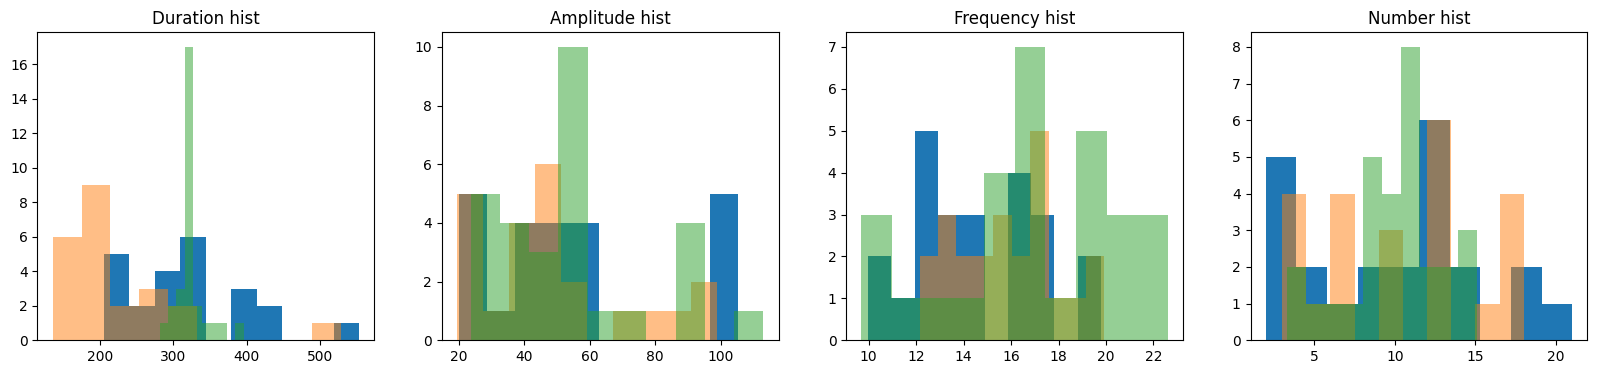

In [58]:
f, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].hist(test_samples_char_true[:, 0])
axes[0].hist(test_samples_char_pred[:, 0], alpha=0.5)
axes[0].hist(all_preds_chars[0], alpha=0.5)


axes[0].set_title("Duration hist")

axes[1].hist(test_samples_char_true[:, 1])
axes[1].hist(test_samples_char_pred[:, 1], alpha=0.5)
axes[1].hist(all_preds_chars[1], alpha=0.5)


axes[1].set_title("Amplitude hist")

axes[2].hist(test_samples_char_true[:, 2])
axes[2].hist(test_samples_char_pred[:, 2], alpha=0.5)
axes[2].hist(all_preds_chars[2], alpha=0.5)


axes[2].set_title("Frequency hist")

axes[3].hist(test_samples_char_true[:, 3])
axes[3].hist(test_samples_char_pred[:, 3], alpha=0.5)
axes[3].hist(all_preds_chars[3], alpha=0.5)


axes[3].set_title("Number hist")

(0.0, 200.0)

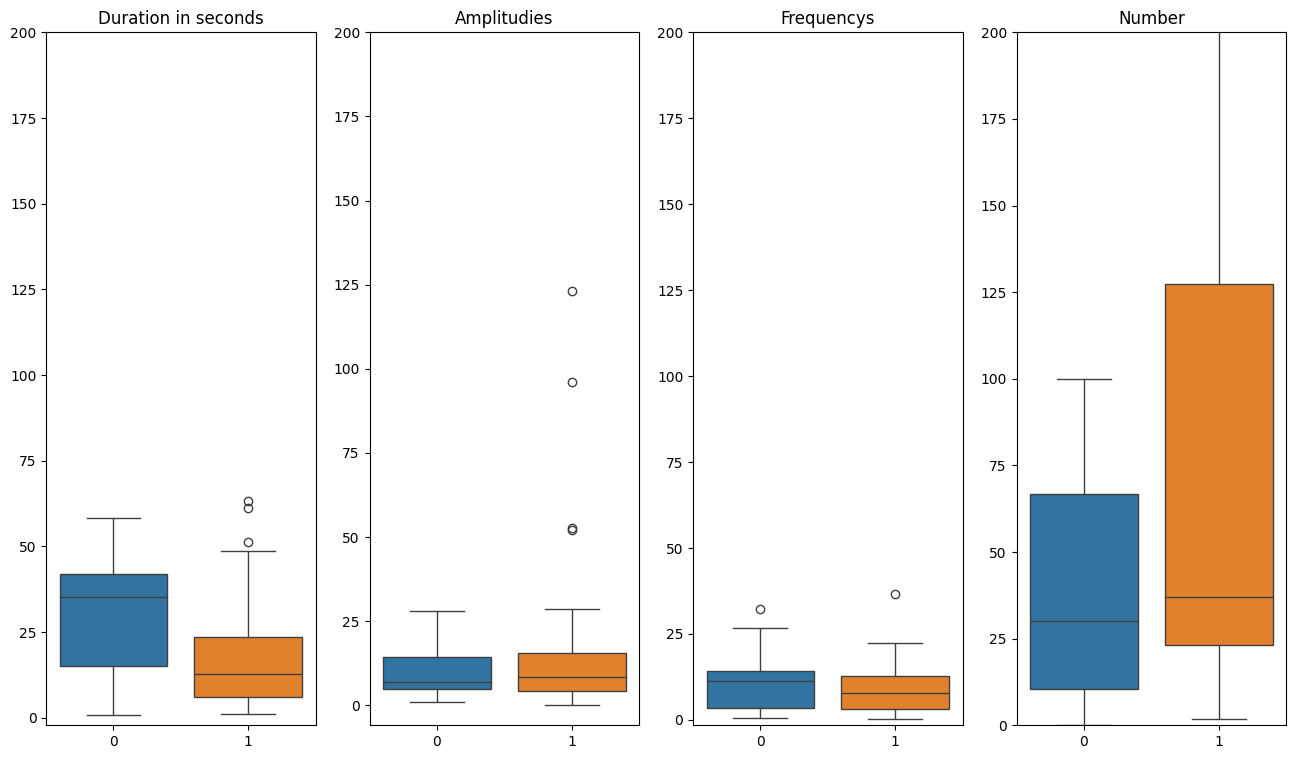

In [60]:
f, axes = plt.subplots(1, 4, figsize=(16, 9))
sns.boxplot([epi_dif.T[0] / test_samples_char_true.T[0] * 100, abs_difs[0] / all_answers[0] * 100], ax=axes[0])
axes[0].set_title("Duration in seconds")

axes[0].set_ylim(top=200)

sns.boxplot([epi_dif.T[1] / test_samples_char_true.T[1] * 100, abs_difs[1] / all_answers[1] * 100], ax=axes[1])
axes[1].set_title("Amplitudies")
axes[1].set_ylim(top=200)

sns.boxplot([epi_dif.T[2] / test_samples_char_true.T[2] * 100, abs_difs[2] / all_answers[2] * 100], ax=axes[2])

axes[2].set_title("Frequencys")
axes[2].set_ylim(top=200)


sns.boxplot([epi_dif.T[3] / test_samples_char_true.T[3] * 100, abs_difs[3] / all_answers[3] * 100], ax=axes[3])
axes[3].set_title("Number")
axes[3].set_ylim(bottom=0, top=200)


In [61]:
mean_dif_test = []
mean_dif_train = []

for i in range(4):
    mean_dif_test.append(np.abs(test_samples_char_true[:, i].mean() - test_samples_char_true[:, i]))
    mean_dif_train.append(np.abs(np.array(train_mean_predicts).T[i] - all_answers[i]))    

(0.0, 200.0)

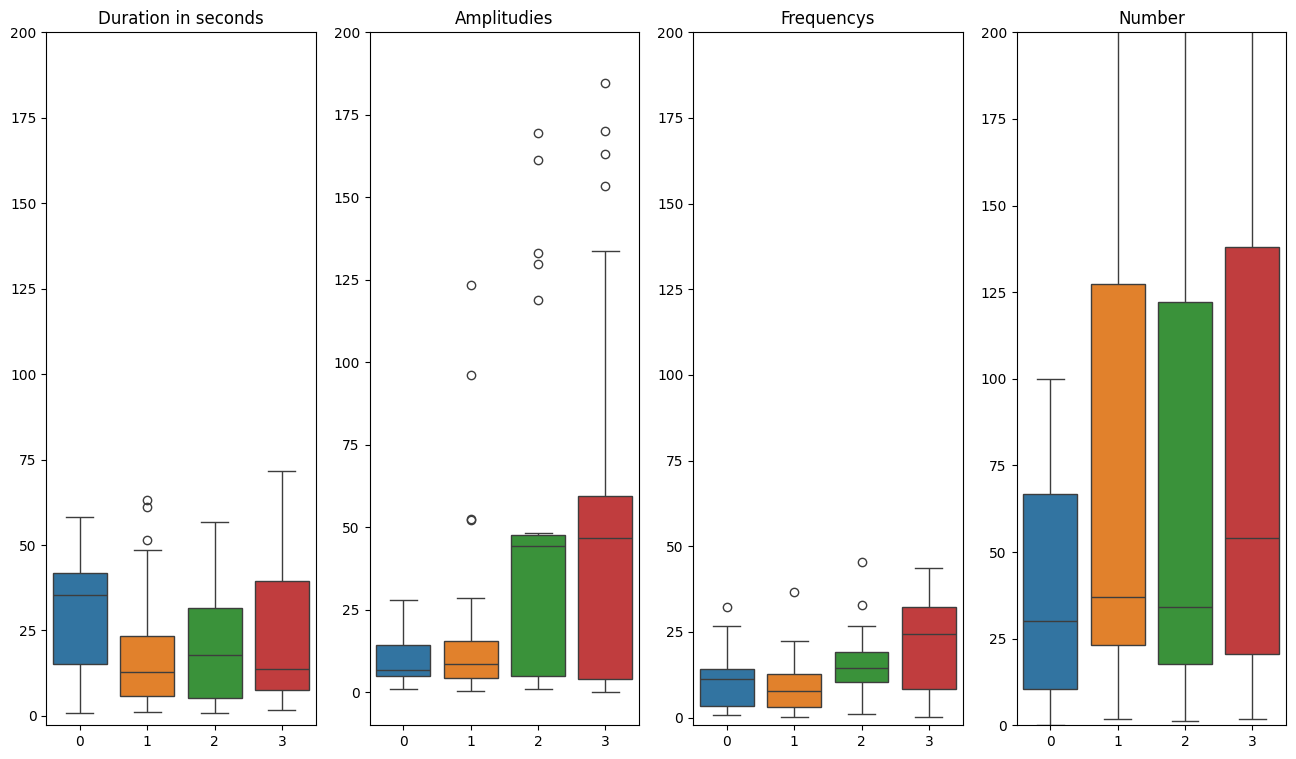

In [62]:
f, axes = plt.subplots(1, 4, figsize=(16, 9))
sns.boxplot([epi_dif.T[0] / test_samples_char_true.T[0] * 100, abs_difs[0] / all_answers[0] * 100, 
             mean_dif_test[0]/ test_samples_char_true.T[0] * 100, mean_dif_train[0] / all_answers[0] * 100], ax=axes[0])
axes[0].set_title("Duration in seconds")

axes[0].set_ylim(top=200)

sns.boxplot([epi_dif.T[1] / test_samples_char_true.T[1] * 100, abs_difs[1] / all_answers[1] * 100, 
             mean_dif_test[1]/ test_samples_char_true.T[1] * 100, mean_dif_train[1] / all_answers[1] * 100], ax=axes[1])
axes[1].set_title("Amplitudies")
axes[1].set_ylim(top=200)

sns.boxplot([epi_dif.T[2] / test_samples_char_true.T[2] * 100, abs_difs[2] / all_answers[2] * 100, 
             mean_dif_test[2]/ test_samples_char_true.T[2] * 100, mean_dif_train[2] / all_answers[2] * 100], ax=axes[2])

axes[2].set_title("Frequencys")
axes[2].set_ylim(top=200)


sns.boxplot([epi_dif.T[3] / test_samples_char_true.T[3] * 100, abs_difs[3] / all_answers[3] * 100, 
             mean_dif_test[3]/ test_samples_char_true.T[3] * 100, mean_dif_train[3] / all_answers[3] * 100], ax=axes[3])
axes[3].set_title("Number")
axes[3].set_ylim(bottom=0, top=200)


(0.0, 200.0)

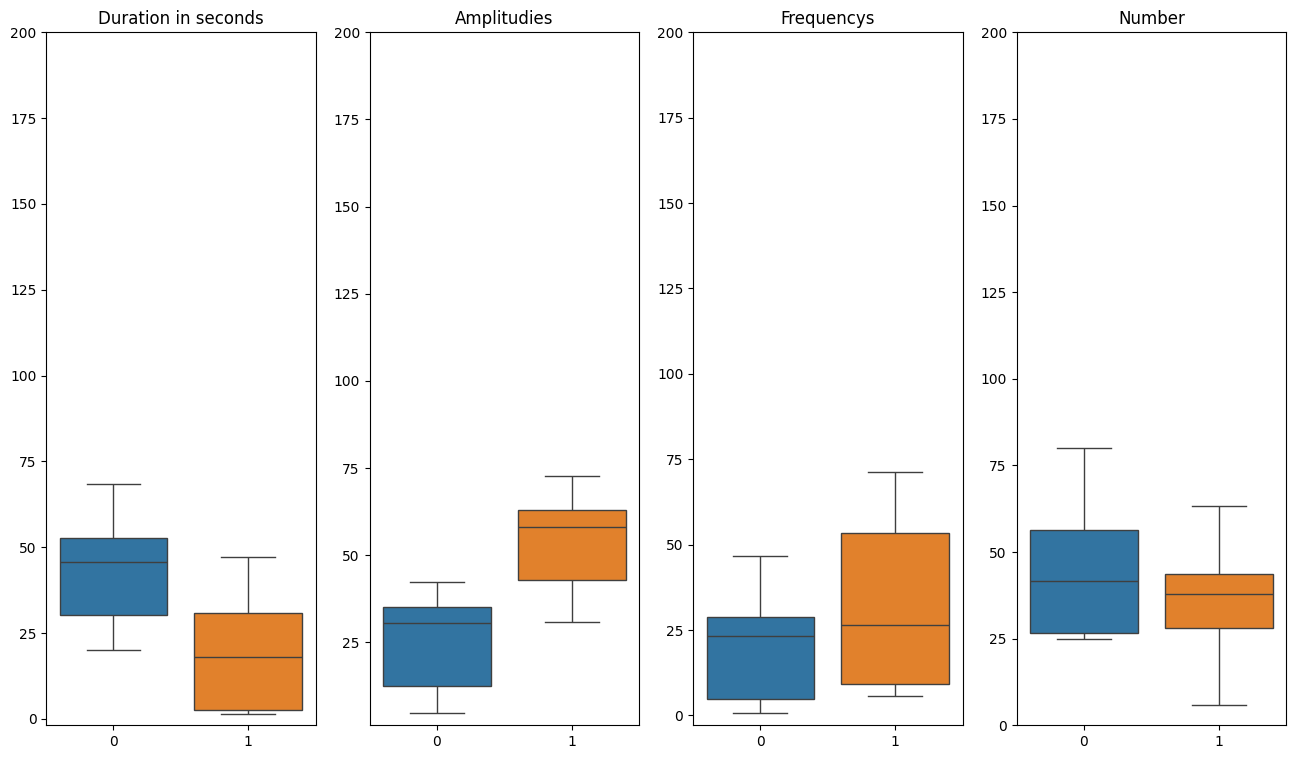

In [54]:
f, axes = plt.subplots(1, 4, figsize=(16, 9))
sns.boxplot([epi_dif.T[0] / test_samples_char_true.T[0] * 100, abs_difs[0] / all_answers[0] * 100], ax=axes[0])
axes[0].set_title("Duration in seconds")

axes[0].set_ylim(top=200)

sns.boxplot([epi_dif.T[1] / test_samples_char_true.T[1] * 100, abs_difs[1] / all_answers[1] * 100], ax=axes[1])
axes[1].set_title("Amplitudies")
axes[1].set_ylim(top=200)

sns.boxplot([epi_dif.T[2] / test_samples_char_true.T[2] * 100, abs_difs[2] / all_answers[2] * 100], ax=axes[2])

axes[2].set_title("Frequencys")
axes[2].set_ylim(top=200)


sns.boxplot([epi_dif.T[3] / test_samples_char_true.T[3] * 100, abs_difs[3] / all_answers[3] * 100], ax=axes[3])
axes[3].set_title("Number")
axes[3].set_ylim(bottom=0, top=200)
